# **Data import & import**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/AI hackathon/data/')

In [4]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import cumtrapz
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

train_features =pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test = pd.read_csv('test_features.csv')
submission = pd.read_csv('sample_submission.csv')

# **Data Observation**
index 26 : Non-Exercise 

id, 600

train data 3125

test data 782



In [5]:
train_features

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [6]:
#id 별로 각각 600개의 데이터가 있음을 확인   
train_features['id'].value_counts()

2047    600
1347    600
2378    600
1354    600
2379    600
       ... 
1699    600
675     600
2722    600
1698    600
0       600
Name: id, Length: 3125, dtype: int64

In [7]:
#train_labels.csv 에서 id 가 수행한 동작과 그에 따른 label값을 확인
train_labels

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


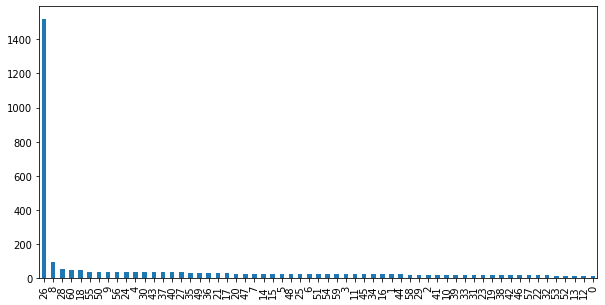

In [8]:
# 26번 데이터는 Non-Exercise data로 train 데이터의 절반 이상을 차지하고 있다
plt.figure(figsize=(10,5))
train_labels['label'].value_counts().plot(kind='bar')

# **Data Preprocessing**
data split, data scaling ... 

*  X_train_acc, X_train_gy 
*  X_test_acc, X_test_gy



In [9]:
# 데이터 분할
act_list = train_features.iloc[:,2:].columns
acc_list = ['acc_x','acc_y','acc_z']
gy_list = ['gy_x','gy_y','gy_z']
act_list

Index(['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z'], dtype='object')

In [10]:
# Scaling
# sklearn 의 data preprocessing - sklearn에서 제공하는 기본 스케일러 중 하나 
scaler = StandardScaler()
train_features[act_list] = scaler.fit_transform(train_features[act_list])
test[act_list] = scaler.transform(test[act_list])
train_features

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,2.307314,-0.029939,-0.432104,0.011776,-0.410859,-0.461007
1,0,1,2.421086,-0.063321,-0.504058,0.026484,-0.528052,-0.365459
2,0,2,2.444664,-0.056749,-0.654199,-0.037962,-0.596041,-0.366767
3,0,3,2.428612,-0.116782,-0.573407,0.066099,-0.725311,-0.401232
4,0,4,2.439475,-0.044220,-0.588886,0.091969,-0.784094,-0.408413
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.367432,-0.845648,0.503707,-0.461266,-1.413128,-1.092639
1874996,3124,596,-0.326315,-0.845833,0.578875,-0.474109,-1.382884,-1.097377
1874997,3124,597,-0.300794,-0.859728,0.652722,-0.436694,-1.341672,-1.136169
1874998,3124,598,-0.253120,-0.886873,0.673002,-0.367051,-1.346630,-1.148831


In [11]:
# acceleromete, gyroscope sensor feature split
def sensor_split(data):
  X_acc = []
  X_gy = []

  for i in tqdm(data['id'].unique()):
      temp_acc = np.array(data[data['id'] == i].loc[:,acc_list])
      temp_gy = np.array(data[data['id'] == i].loc[:,gy_list])
      X_acc.append(temp_acc)
      X_gy.append(temp_gy)
      
  X_acc = np.array(X_acc).reshape(-1,600,3)
  X_gy = np.array(X_gy).reshape(-1,600,3)

  return X_acc, X_gy

In [12]:
X_train_acc, X_train_gy = sensor_split(train_features)

X_test_acc, X_test_gy = sensor_split(test)

100%|██████████| 782/782 [00:03<00:00, 250.07it/s]


# **Data Augmentation**

time warping, permutation...

In [13]:
# 데이터 증강

# Time Warping
sigma = 0.2
knot = 4

def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()

def DistortTimesteps(X, sigma):
    tt = GenerateRandomCurves(X, sigma) # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
    tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
    tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
    return tt_cum

def TimeWarp(X, sigma):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,1], X[:,1])
    X_new[:,2] = np.interp(x_range, tt_new[:,2], X[:,2])
    return X_new

# Permutation
def Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile == True:
        segs = np.zeros(nPerm+1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0]-minSegLength, nPerm-1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:]-segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii]+1],:]
        X_new[pp:pp+len(x_temp),:] = x_temp
        pp += len(x_temp)
    return (X_new)

# Rotation
def Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

# Jittering
def Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

# Magnitude Warping
def MagWarp(X, sigma):
    return X * GenerateRandomCurves(X, sigma)

In [14]:
def ts_aug(data, method,sigma):
  new_data=[]
  for i in range(data.shape[0]):
    temp=list(method(data[i], sigma))
    new_data.append(temp)
  return np.array(new_data)

In [15]:
X_train_acc_comb = Permutation(Jitter(X_train_acc))
X_train_acc_perm = Permutation(X_train_acc)
X_train_acc_timew = ts_aug(X_train_acc, TimeWarp, 0.2)
X_train_acc_magw = ts_aug(X_train_acc, MagWarp, 0.2)

X_train_gy_comb = Permutation(Jitter(X_train_gy))
X_train_gy_perm = Permutation(X_train_gy)
X_train_gy_timew = ts_aug(X_train_gy, TimeWarp, 0.2)
X_train_gy_magw = ts_aug(X_train_gy, MagWarp, 0.2)

In [16]:
X_train_acc = np.append(X_train_acc, X_train_acc_comb, axis=0)
X_train_acc = np.append(X_train_acc, X_train_acc_perm, axis=0)
X_train_acc = np.append(X_train_acc, X_train_acc_timew, axis=0)
X_train_acc = np.append(X_train_acc, X_train_acc_magw, axis=0)

X_train_gy = np.append(X_train_gy, X_train_gy_comb, axis=0)
X_train_gy = np.append(X_train_gy, X_train_gy_perm, axis=0)
X_train_gy = np.append(X_train_gy, X_train_gy_timew, axis=0)
X_train_gy = np.append(X_train_gy, X_train_gy_magw, axis=0)

In [17]:
acc = [e for sl in X_train_acc for e in sl]

df_report = np.stack(acc, axis = 0)
df_acc = pd.DataFrame(df_report, columns= ['acc_x', 'acc_y', 'acc_z'])

df_acc

,acc_x,acc_y,acc_z
0,2.307314,-0.029939,-0.432104
1,2.421086,-0.063321,-0.504058
2,2.444664,-0.056749,-0.654199
3,2.428612,-0.116782,-0.573407
4,2.439475,-0.044220,-0.588886
...,...,...,...
9374995,-0.334355,-0.854299,0.612537
9374996,-0.299734,-0.851844,0.709902
9374997,-0.278914,-0.863059,0.807257
9374998,-0.236955,-0.887348,0.839422


In [18]:
# gy

gy = [e for sl in X_train_gy for e in sl]

df_report = np.stack(gy, axis = 0)
df_gy = pd.DataFrame(df_report, columns= ['gy_x', 'gy_y', 'gy_z'])

df_gy

,gy_x,gy_y,gy_z
0,0.011776,-0.410859,-0.461007
1,0.026484,-0.528052,-0.365459
2,-0.037962,-0.596041,-0.366767
3,0.066099,-0.725311,-0.401232
4,0.091969,-0.784094,-0.408413
...,...,...,...
9374995,-0.454192,-1.851949,-1.212585
9374996,-0.465191,-1.811542,-1.222555
9374997,-0.426950,-1.756751,-1.270681
9374998,-0.357564,-1.762376,-1.289836


In [19]:
# acc, gy 데이터프레임 병합

df_aug_result = pd.concat([df_acc, df_gy], axis = 1)
df_aug_result.insert(0, 'id', 0)
df_aug_result.insert(1, 'time', 1)
df_aug_result

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,1,2.307314,-0.029939,-0.432104,0.011776,-0.410859,-0.461007
1,0,1,2.421086,-0.063321,-0.504058,0.026484,-0.528052,-0.365459
2,0,1,2.444664,-0.056749,-0.654199,-0.037962,-0.596041,-0.366767
3,0,1,2.428612,-0.116782,-0.573407,0.066099,-0.725311,-0.401232
4,0,1,2.439475,-0.044220,-0.588886,0.091969,-0.784094,-0.408413
...,...,...,...,...,...,...,...,...
9374995,0,1,-0.334355,-0.854299,0.612537,-0.454192,-1.851949,-1.212585
9374996,0,1,-0.299734,-0.851844,0.709902,-0.465191,-1.811542,-1.222555
9374997,0,1,-0.278914,-0.863059,0.807257,-0.426950,-1.756751,-1.270681
9374998,0,1,-0.236955,-0.887348,0.839422,-0.357564,-1.762376,-1.289836


In [20]:
df_aug_result.loc[600*0:600*0+600, 'time']

0      1
1      1
2      1
3      1
4      1
      ..
596    1
597    1
598    1
599    1
600    1
Name: time, Length: 601, dtype: int64

In [21]:
train = df_aug_result
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,1,2.307314,-0.029939,-0.432104,0.011776,-0.410859,-0.461007
1,0,1,2.421086,-0.063321,-0.504058,0.026484,-0.528052,-0.365459
2,0,1,2.444664,-0.056749,-0.654199,-0.037962,-0.596041,-0.366767
3,0,1,2.428612,-0.116782,-0.573407,0.066099,-0.725311,-0.401232
4,0,1,2.439475,-0.044220,-0.588886,0.091969,-0.784094,-0.408413
...,...,...,...,...,...,...,...,...
9374995,0,1,-0.334355,-0.854299,0.612537,-0.454192,-1.851949,-1.212585
9374996,0,1,-0.299734,-0.851844,0.709902,-0.465191,-1.811542,-1.222555
9374997,0,1,-0.278914,-0.863059,0.807257,-0.426950,-1.756751,-1.270681
9374998,0,1,-0.236955,-0.887348,0.839422,-0.357564,-1.762376,-1.289836


In [22]:
n = 4
train_labels_copy = train_labels.copy()
for i in range(0, n):
    train_labels = train_labels.append(train_labels_copy, ignore_index=True)
train_labels = train_labels.reset_index()
train_labels

,index,id,label,label_desc
0,0,0,37,Shoulder Press (dumbbell)
1,1,1,26,Non-Exercise
2,2,2,3,Biceps Curl (band)
3,3,3,26,Non-Exercise
4,4,4,26,Non-Exercise
...,...,...,...,...
15620,15620,3120,26,Non-Exercise
15621,15621,3121,26,Non-Exercise
15622,15622,3122,15,Dynamic Stretch (at your own pace)
15623,15623,3123,26,Non-Exercise


# **속도, 각속도 추가**

In [ ]:
# 속도, 각속도 추가
feature_names = ['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']

grad_cols=[]
for col in feature_names:
    grad_cols.append(f"grad_{col}")

integ_cols = []
for col in feature_names:
    integ_cols.append(f"integ_{col}")
    
total_feature_names = feature_names + grad_cols + integ_cols

for uid in tqdm(train['id'].unique()):
    temp = train.loc[train['id']==uid, feature_names]
    grad = np.gradient(temp, axis=0)
    train.loc[train['id']==uid, grad_cols] = grad
    
for uid in tqdm(test['id'].unique()):
    temp = test.loc[test['id']==uid, feature_names]
    grad = np.gradient(temp, axis=0)
    test.loc[test['id']==uid, grad_cols] = grad
    
print(train.shape, test.shape)
train.head()

for uid in tqdm(train['id'].unique()):
    temp = train.loc[train['id']==uid, feature_names]
    integ = cumtrapz(temp, initial=0, axis=0)
    train.loc[train['id']==uid, integ_cols] = integ
    
for uid in tqdm(test['id'].unique()):
    temp = test.loc[test['id']==uid, feature_names]
    integ = cumtrapz(temp, initial=0, axis=0)
    test.loc[test['id']==uid, integ_cols] = integ
    
print(train.shape, test.shape)
train

 12%|█▏        | 837/6707 [06:27<45:20,  2.16it/s]


KeyboardInterrupt: ignored

In [ ]:
# 가속도 feature 추가
train['acc_t']  = train.apply(lambda x : (x['acc_x']**2 + x['acc_y'] **2 +  x['acc_z'] ** 2 )**(1/3), axis=1)
test['acc_t']  = test.apply(lambda x : (x['acc_x']**2 + x['acc_y'] **2 +  x['acc_z'] ** 2 )**(1/3), axis=1)

display(train)
display(test)

KeyboardInterrupt: ignored

In [1]:
out_list = []
for i in range(3125):
  label = train_label.loc[(train_label['id'] == i),'label'].values[0,1] 
  out_list.append(label)

out_list = np.array(out_list)
#out_list = np.expand_dims(np.array(out_list), axis = 1)
label = torch.from_numpy(out_list)  

NameError: ignored

# **모델링**

In [29]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn.model_selection import StratifiedKFold # TimeSeriesSplit
from sklearn.metrics import accuracy_score

from keras.callbacks import EarlyStopping

In [25]:
X=tf.reshape(np.array(train.iloc[:,2:]),[-1, 600, 6])
X.shape

TensorShape([15625, 600, 6])

In [26]:
y = tf.keras.utils.to_categorical(train_labels['label']) 
y.shape

(15625, 61)

In [27]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600, 6])
test_X.shape

TensorShape([782, 600, 6])

In [28]:
#가벼운 모델 생성
model = Sequential()
model.add(LSTM(32, input_shape=(600,6)))
model.add(Dense(128, activation='relu'))
model.add(Dense(61, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
stfold = StratifiedKFold(n_splits=5, shuffle=True)
idx_iter = 0 
skf_accuracy=[]

for train_idx, valid_idx in stfold.split(X, train_labels['label']) :

  Y_train, Y_valid = np.array(pd.get_dummies(train_labels['label']))[train_idx], np.array(pd.get_dummies(train_labels['label']))[valid_idx]
  X_train, X_valid = tf.gather(X, train_idx), tf.gather(X, valid_idx)

  early_stopping = EarlyStopping()
  model.fit(X_train, Y_train, epochs=10, batch_size=2048, validation_split=0.2, callbacks=[early_stopping])
  pred = model.predict(X_valid)

  # 반복 시 마다 정확도 측정 -> 수정해야함; 
  idx_iter += 1 
  #accuracy = np.round(accuracy_score(Y_valid, pred), 4)
  train_size = X_train.shape[0]
  test_size = X_valid.shape[0]

  print("\n##### 교차 검증: {}  #####" .format(idx_iter))
  print('학습 레이블 데이터 분포:\n ', Y_train.shape[0])
  print('검증 레이블 데이터 분포:\n ', Y_valid.shape[0], '\n\n')
  #skf_accuracy.append(accuracy)

#print("\n## 평균 검증 정확도: ", np.mean(skf_accuracy))

Epoch 1/10
5/5 [==============================] - 15s 3s/step - loss: 3.8190 - accuracy: 0.4575 - val_loss: 3.6525 - val_accuracy: 0.4828

##### 교차 검증: 1  #####
학습 레이블 데이터 분포:
  12500
검증 레이블 데이터 분포:
  3125 


Epoch 1/10
5/5 [==============================] - 16s 3s/step - loss: 3.5501 - accuracy: 0.4839 - val_loss: 3.2945 - val_accuracy: 0.4872

##### 교차 검증: 2  #####
학습 레이블 데이터 분포:
  12500
검증 레이블 데이터 분포:
  3125 


Epoch 1/10
5/5 [==============================] - 15s 3s/step - loss: 3.1837 - accuracy: 0.4871 - val_loss: 2.9205 - val_accuracy: 0.4784

##### 교차 검증: 3  #####
학습 레이블 데이터 분포:
  12500
검증 레이블 데이터 분포:
  3125 


Epoch 1/10
5/5 [==============================] - 14s 3s/step - loss: 2.9065 - accuracy: 0.4855 - val_loss: 2.7342 - val_accuracy: 0.4860

##### 교차 검증: 4  #####
학습 레이블 데이터 분포:
  12500
검증 레이블 데이터 분포:
  3125 


Epoch 1/10
5/5 [==============================] - 14s 3s/step - loss: 2.7992 - accuracy: 0.4853 - val_loss: 2.6786 - val_accuracy: 0.4864

##### 교차 검증: 5  #####
학습 

In [32]:
prediction=model.predict(test_X)
prediction

array([[0.0058751 , 0.00551735, 0.00724258, ..., 0.00736529, 0.00551179,
        0.01898899],
       [0.00544704, 0.0054266 , 0.00651793, ..., 0.00654501, 0.0053393 ,
        0.01784418],
       [0.00916194, 0.00971693, 0.00828228, ..., 0.00885424, 0.00847415,
        0.02314011],
       ...,
       [0.00652267, 0.006076  , 0.00733863, ..., 0.00741636, 0.00582803,
        0.01886717],
       [0.01396748, 0.01578736, 0.0122266 , ..., 0.01320447, 0.01477159,
        0.01762566],
       [0.00694499, 0.00566256, 0.00571303, ..., 0.00501723, 0.00776332,
        0.01098256]], dtype=float32)

In [33]:
prediction.shape

(782, 61)

In [34]:
submission.iloc[:,1:]=prediction

In [35]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.005875,0.005517,0.007243,0.004926,0.010043,0.004509,0.003999,0.007083,0.023378,0.018466,0.004669,0.009810,0.004157,0.004178,0.007421,0.004956,0.004729,0.005773,0.016233,0.006810,0.008140,0.004673,0.004604,0.003445,0.012924,0.004061,0.553449,0.007662,0.006358,0.003916,0.013582,0.006872,0.004498,0.003897,0.004726,0.007273,0.011403,0.006901,0.007710,0.003536,0.011440,0.003617,0.017426,0.006709,0.006676,0.005987,0.005609,0.009418,0.005995,0.007608,0.005804,0.007627,0.005012,0.004806,0.005381,0.005662,0.008460,0.005488,0.007365,0.005512,0.018989
1,3126,0.005447,0.005427,0.006518,0.004758,0.009924,0.004263,0.003703,0.006437,0.021907,0.018029,0.004306,0.009168,0.004008,0.003733,0.006943,0.004487,0.004364,0.005357,0.016826,0.006323,0.007665,0.004538,0.004193,0.003109,0.012123,0.003880,0.577571,0.007260,0.005961,0.003704,0.013165,0.006355,0.004256,0.003512,0.004452,0.006760,0.010923,0.006592,0.007373,0.003279,0.011025,0.003439,0.016021,0.006133,0.006535,0.005489,0.005160,0.009016,0.005954,0.007386,0.005400,0.007122,0.004638,0.004398,0.005163,0.005357,0.008317,0.005118,0.006545,0.005339,0.017844
2,3127,0.009162,0.009717,0.008282,0.006573,0.013582,0.007438,0.006611,0.010100,0.024422,0.020351,0.005522,0.012690,0.006371,0.005784,0.009623,0.007553,0.007764,0.008602,0.020644,0.009689,0.012512,0.007934,0.006591,0.005449,0.015358,0.007287,0.379816,0.011364,0.010366,0.005863,0.016035,0.009194,0.007269,0.005971,0.007673,0.008893,0.013873,0.011033,0.010677,0.006119,0.017905,0.006362,0.020780,0.010952,0.009276,0.007810,0.008431,0.014477,0.009623,0.011017,0.008485,0.009983,0.007508,0.007489,0.009080,0.007806,0.015146,0.007643,0.008854,0.008474,0.023140
3,3128,0.006410,0.006036,0.008151,0.005677,0.011290,0.004957,0.004582,0.007930,0.024495,0.019574,0.005340,0.011093,0.004723,0.005091,0.008402,0.005584,0.005275,0.006650,0.017295,0.007699,0.008979,0.005364,0.005290,0.003982,0.013816,0.004664,0.506178,0.008477,0.006963,0.004518,0.015001,0.007724,0.005350,0.004338,0.005164,0.008063,0.012632,0.008047,0.008247,0.004040,0.012668,0.004183,0.018993,0.007473,0.007559,0.006682,0.006445,0.010407,0.006583,0.008430,0.006558,0.008303,0.005432,0.005365,0.005904,0.006238,0.009076,0.006403,0.008300,0.006236,0.019669
4,3129,0.007431,0.006797,0.008653,0.005613,0.011610,0.005682,0.004452,0.008572,0.025205,0.019813,0.005427,0.010408,0.005452,0.004462,0.008150,0.005739,0.005651,0.006579,0.019000,0.008687,0.009796,0.005815,0.005618,0.004165,0.014212,0.005401,0.486149,0.007971,0.008294,0.004856,0.013540,0.008204,0.005003,0.004913,0.006223,0.008624,0.012850,0.007524,0.009035,0.004498,0.012374,0.004590,0.017970,0.008147,0.008188,0.006763,0.006531,0.011263,0.007060,0.009046,0.006475,0.009048,0.006351,0.005652,0.006529,0.006678,0.010826,0.006305,0.008343,0.006687,0.019099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.007129,0.007243,0.006897,0.005204,0.011538,0.005599,0.005435,0.007820,0.022871,0.019940,0.004468,0.011135,0.004807,0.004609,0.008064,0.005868,0.006018,0.006634,0.018231,0.007739,0.009990,0.005840,0.004938,0.003926,0.013442,0.005115,0.490442,0.009405,0.008216,0.004411,0.015843,0.007203,0.005523,0.004421,0.005682,0.007313,0.011943,0.008777,0.008928,0.004482,0.014267,0.004723,0.018519,0.008206,0.007272,0.006507,0.006417,0.011534,0.007291,0.008779,0.006697,0.008521,0.005629,0.005859,0.006866,0.006291,0.011774,0.006167,0.007199,0.006713,0.021679
778,3903,0.016737,0.017932,0.013500,0.011407,0.020298,0.014449,0.011689,0.016997,0.028945,0.011028,0.008908,0.012565,0.010146,0.006470,0.014411,0.016627,0.012394,0.020270,0.016157,0.019343,0.019540,0.018303,0.012908,0.013395,0.017369

In [36]:
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/AI hackathon/data/baseline_aug_1.csv', index=False)